In [16]:
# -*- coding: utf-8 -*-
"""
This script demonstrates how to correct the positional misalignment of images
using normalized cross-correlation. It is designed to be educational for students
learning image processing with Python.
"""

# 1. Preparation
# ==============================================================================
# Import necessary libraries
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.interpolate import RegularGridInterpolator
from scipy.signal import fftconvolve
import cv2
import os

# --- Student Action Required ---
# To run this script in Google Colab, you need to:
# 1. Create a folder named "Colab Notebooks/image_analysis_share" in your Google Drive.
# 2. Copy the folder "python応用_受精卵画像の位置ズレ補正" into the "image_analysis_share" folder.
# 3. Place the original images into the "originalData" subfolder.
# 4. Mount your Google Drive to the Colab environment.

from google.colab import drive
drive.mount('/content/drive')

# --- Configuration ---
# File and directory settings
# Note: Update this path if you are not using Google Colab.
BASE_PATH = "./drive/MyDrive/Colab Notebooks/1. image_alignment/"
# BASE_PATH = "./" # Assuming the script is in the same directory as the data folders
FNAME = "PM_nuc_sample1_MAX_220520_2354-1968col_T60,z31,zo3,512,sp1,av0,la2_crop5_elong"
ORIGINAL_DATA_DIR = "original_images"
NORMALIZED_DATA_DIR = "aligned_images"

# Image dimensions
IMG_WIDTH = 512
IMG_HEIGHT = 512

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
# 2. Image Manipulation Functions
# ==============================================================================

def show_image(image, title="Image", cmap="gray"):
    """
    Displays an image using matplotlib.

    Args:
        image (np.array): The image to be displayed.
        title (str): The title of the plot.
        cmap (str): The colormap to use for grayscale images.
    """
    plt.figure(dpi=100)
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def fill_shifted_area(image, shift_y, shift_x, noise_level):
    """
    Fills the empty areas of a shifted image with black or random noise.

    Args:
        image (np.array): The image that has been shifted.
        shift_y (int): The vertical shift amount.
        shift_x (int): The horizontal shift amount.
        noise_level (int): The upper bound for random integer noise. If 0,
                           the area is filled with black.

    Returns:
        np.array: The image with filled empty areas.
    """
    height, width = image.shape

    # Fill vertical empty space
    if shift_y < 0:
        fill_area = image[height + shift_y:height, :]
        if noise_level == 0:
            fill_area.fill(0)
        else:
            image[height + shift_y:height, :] = np.random.randint(noise_level, size=(-shift_y, width))
    elif shift_y > 0:
        fill_area = image[0:shift_y, :]
        if noise_level == 0:
            fill_area.fill(0)
        else:
            image[0:shift_y, :] = np.random.randint(noise_level, size=(shift_y, width))

    # Fill horizontal empty space
    if shift_x < 0:
        fill_area = image[:, width + shift_x:width]
        if noise_level == 0:
            fill_area.fill(0)
        else:
            image[:, width + shift_x:width] = np.random.randint(noise_level, size=(height, -shift_x))
    elif shift_x > 0:
        fill_area = image[:, 0:shift_x]
        if noise_level == 0:
            fill_area.fill(0)
        else:
            image[:, 0:shift_x] = np.random.randint(noise_level, size=(height, shift_x))

    return image

def translate_image(image, shift_y, shift_x, noise_level=0, add_noise=False):
    """
    Translates (shifts) an image vertically and horizontally.

    Args:
        image (np.array): The input image (2D or 3D).
        shift_y (int): The number of pixels to shift vertically (positive is down).
        shift_x (int): The number of pixels to shift horizontally (positive is right).
        noise_level (int): The intensity of the mosaic/noise effect.
        add_noise (bool): If True, adds a mosaic/noise effect to the empty areas.

    Returns:
        np.array: The translated image.
    """
    shifted_img = np.copy(image)

    # Handle 2D (grayscale) and 3D (color) images
    if image.ndim == 2:
        shifted_img = np.roll(shifted_img, shift_y, axis=0)
        shifted_img = np.roll(shifted_img, shift_x, axis=1)
        if add_noise:
            shifted_img = fill_shifted_area(shifted_img, shift_y, shift_x, noise_level)
    elif image.ndim == 3:
        for i in range(image.shape[-1]): # Iterate through color channels
            shifted_img[:,:,i] = np.roll(shifted_img[:,:,i], shift_y, axis=0)
            shifted_img[:,:,i] = np.roll(shifted_img[:,:,i], shift_x, axis=1)
            if add_noise:
                shifted_img[:,:,i] = fill_shifted_area(shifted_img[:,:,i], shift_y, shift_x, noise_level)

    return shifted_img

def rotate_image(image, angle, center=None, scale=1.0):
    """
    Rotates an image by a given angle around a center point.

    Args:
        image (np.array): The image to rotate.
        angle (float): The rotation angle in degrees. Positive values mean
                       counter-clockwise rotation.
        center (tuple): The center of rotation (x, y). If None, the image
                        center is used.
        scale (float): An optional scaling factor.

    Returns:
        np.array: The rotated image.
    """
    (h, w) = image.shape[:2]
    if center is None:
        center = (w // 2, h // 2)

    # Get the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, scale)
    # Perform the rotation
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

In [50]:
# 3. Normalized Cross-Correlation and Misalignment Correction
# ==============================================================================

def normxcorr2(template, image, mode="full"):
    """
    Computes the normalized 2D cross-correlation of a template and an image.
    This function is essential for template matching.
    Input arrays should be floating-point numbers.

    Args:
        template (np.array): The template or filter for cross-correlation.
                             Must have dimensions less than or equal to the image.
        image (np.array): The image to be searched.
        mode (str): "full", "valid", or "same". Determines the output size.

    Returns:
        np.array: The normalized cross-correlation map.
    """
    if np.ndim(template) > np.ndim(image) or \
       any(t > i for t, i in zip(template.shape, image.shape)):
        print("normxcorr2: TEMPLATE is larger than IMAGE. Arguments may be swapped.")

    # Subtract the mean to make the correlation illumination-invariant
    template = template - np.mean(template)
    image = image - np.mean(image)

    # Pad the template to the size of the image for FFT
    a1 = np.ones(template.shape)

    # Flip template for convolution, which is equivalent to correlation
    ar = np.flipud(np.fliplr(template))

    # Perform convolution using FFT for speed
    out = fftconvolve(image, ar.conj(), mode=mode)

    # Compute local sums of squares
    image_sq_sum = fftconvolve(np.square(image), a1, mode=mode)
    image_sum_sq = np.square(fftconvolve(image, a1, mode=mode)) / np.prod(template.shape)

    image_denom = image_sq_sum - image_sum_sq
    image_denom[image_denom < 0] = 0 # Remove small precision errors

    template_denom = np.sum(np.square(template))

    with np.errstate(divide='ignore', invalid='ignore'):
        out = out / np.sqrt(image_denom * template_denom)

    # Clean up any non-finite values (resulting from division by zero)
    out[~np.isfinite(out)] = 0

    return out

def find_peak(correlation_map):
    """
    Finds the coordinates and value of the maximum value in a correlation map.

    Args:
        correlation_map (np.array): The 2D array from the cross-correlation.

    Returns:
        list: A list containing [y_peak, x_peak, peak_value].
    """
    ind = np.unravel_index(np.argmax(correlation_map, axis=None), correlation_map.shape)
    return [ind[0], ind[1], correlation_map[ind[0], ind[1]]]

def plot_3d_surface(correlation_map):
    """
    Visualizes the 2D cross-correlation result as a 3D surface plot.

    Args:
        correlation_map (np.array): The 2D correlation map.
    """
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ny, nx = correlation_map.shape
    X = np.arange(0, nx, 1)
    Y = np.arange(0, ny, 1)
    X, Y = np.meshgrid(X, Y)

    surf = ax.plot_surface(X, Y, correlation_map, cmap=cm.viridis, linewidth=0, antialiased=False, alpha=0.6)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter('{x:.02f}')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title("Normalized 2-D Cross-Correlation")
    plt.show()

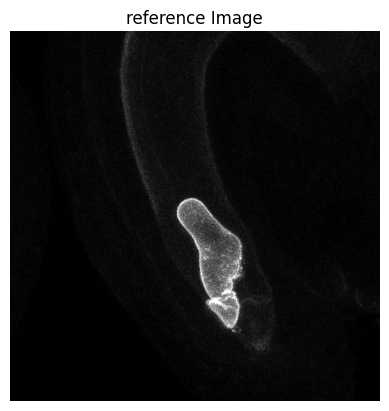

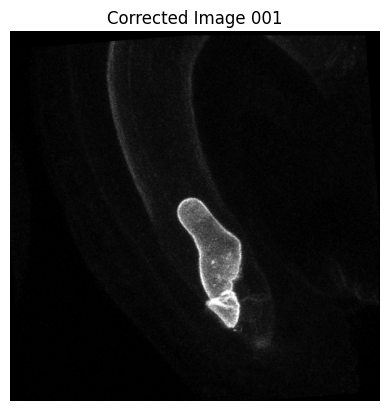

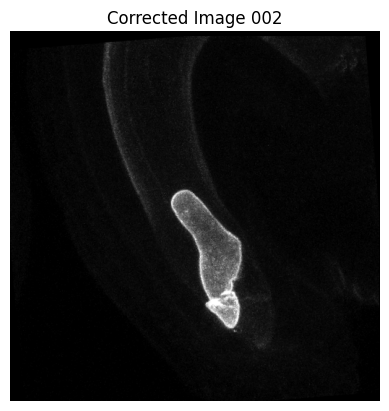

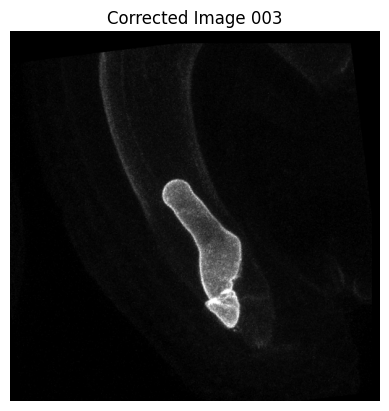

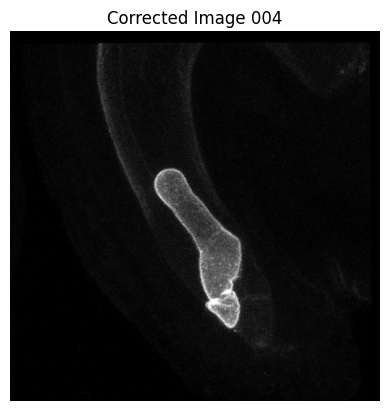

In [73]:
# 4. Main Execution
# ==============================================================================

# Number of frames
t = 5
# Initialize angle_range
angs = -10
ange = 10
angle_range = np.arange(angs,ange,0.5)

if __name__ == '__main__':
    # --- Image Loading ---
    # Load the reference image (img1) and a shifted image (img2)

    # Construct the file path for the reference image
    img_path1 = os.path.join(BASE_PATH, ORIGINAL_DATA_DIR, f"{FNAME}_000.png")

    # Read the image in grayscale
    img1 = cv2.imread(img_path1, 0)

    if img1 is None:
        print(f"Error: Could not load image from {img_path1}")
        print("Please ensure the file path and directory structure are correct.")
    else:

      # Show the reference image again for comparison
      show_image(img1, "reference Image")

      for it in range(1,t):
        # Construct the file path for the shifted image
        img_path2 = os.path.join(BASE_PATH, ORIGINAL_DATA_DIR, f"{FNAME}_{it:03d}.png")

        # Read the image in grayscale
        img2 = cv2.imread(img_path2, 0)

        # Check if the image was loaded correctly
        if img2 is None:
            print(f"Error: Could not load image from {img_path2}")
            print("Please ensure the file path and directory structure are correct.")
        else:
            # --- Misalignment Correction ---
            # Initialize best match
            best_score = -np.inf
            best_rotation = 0
            best_shift = (0, 0)
            best_img2 = None

            # Try all rotation angles
            for theta in angle_range:
              rotated_img2 = rotate_image(img2, theta)
              # print(theta)
              # show_image(rotated_img2, f"rotated Image {it:03d}")

              # Calculate the normalized cross-correlation between the two images
              correlation_map = normxcorr2(img1, rotated_img2, mode="full")

              # Visualize the correlation result
              # plot_3d_surface(correlation_map)

              # Find the peak of the correlation map to determine the displacement
              peak_info = find_peak(correlation_map)
              score = peak_info[2]

              # Update best match if score is higher
              if score > best_score:
                best_score = score

                # Calculate the required correction shift
                # The peak in the 'full' correlation map is relative to the top-left corner
                # of the template within the padded image.
                # Correction = (template_size - 1) - peak_location
                # Since template is img1 and image is img2 (same size), the displacement is:
                # y_shift = peak_y - (IMG_HEIGHT - 1)
                # x_shift = peak_x - (IMG_WIDTH - 1)
                # We need to shift img2 in the opposite direction to align it with img1.
                correction_y = IMG_HEIGHT - (peak_info[0] + 1)
                correction_x = IMG_WIDTH - (peak_info[1] + 1)

                aligned_img2 = rotated_img2
                # Apply the correction to the rotated image
                aligned_img2 = translate_image(aligned_img2, correction_y, correction_x, add_noise=True)

                best_rotation = theta
                best_shift = (correction_y, correction_x)
                best_img2 = aligned_img2

            # --- Display Results ---
            # Show the final corrected image
            show_image(best_img2, f"Corrected Image {it:03d}")

            # Save the final corrected image
            save_path = os.path.join(BASE_PATH, NORMALIZED_DATA_DIR, f"{FNAME}_{it:03d}.png")
            cv2.imwrite(save_path,best_img2)

In [62]:
save_path

'./drive/MyDrive/Colab Notebooks/1. image_alignment/aligned_images/PM_nuc_sample1_MAX_220520_2354-1968col_T60,z31,zo3,512,sp1,av0,la2_crop5_elong_003.png'